In [1]:
import pandas as pd
import numpy as np
import re
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import rc, font_manager

font_path = './malgun.ttf'
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

C:\Users\hajae\anaconda3\envs\pydatavenv\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\hajae\anaconda3\envs\pydatavenv\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\Users\hajae\anaconda3\envs\pydatavenv\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
!pip install openpyxl

## 데이터 불러오기

In [2]:
exc1 = pd.read_excel('./경찰청/경찰청데이터.xlsx', sheet_name=0)
exc2 = pd.read_excel('./경찰청/경찰청데이터.xlsx', sheet_name=1)
exc3 = pd.read_excel('./경찰청/경찰청데이터.xlsx', sheet_name=2)
exc4 = pd.read_excel('./경찰청/경찰청데이터.xlsx', sheet_name=3)

In [3]:
#column 확인하기
col = exc1.columns

In [4]:
missing = pd.DataFrame(np.concatenate([exc1, exc2, exc3, exc4]), columns = col)

## 데이터 확인하기

In [5]:
missing.head()

,대상구분,실종나이,발생일시,등록일시,발견일시,발생지역
0,지적ㆍ자폐성ㆍ정신장애인,13,2015-01-01 08:30,2015-01-01 15:15,2015-01-01 16:10,부산 부산진구 부전2동
1,지적ㆍ자폐성ㆍ정신장애인,36,2014-12-31 00:00,2015-01-01 15:16,2015-01-06 17:00,부산 사하구 장평로
2,지적ㆍ자폐성ㆍ정신장애인,53,2015-01-01 14:00,2015-01-01 17:45,2015-01-02 01:20,경기도 안양시 동안구
3,지적ㆍ자폐성ㆍ정신장애인,48,2015-01-01 17:00,2015-01-01 19:34,2015-01-01 20:10,경기도 양평군 양근로398번길
4,지적ㆍ자폐성ㆍ정신장애인,32,2014-12-31 18:00,2015-01-01 13:47,2015-01-01 17:00,충청북도 청주시 흥덕구


In [6]:
print(missing.info())
display(missing.describe(include='all')) # --> 아동의 실종 건수가 가장 많음 / 경기도 안산시??
print(missing.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232903 entries, 0 to 232902
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   대상구분    232903 non-null  object
 1   실종나이    232903 non-null  object
 2   발생일시    232903 non-null  object
 3   등록일시    232903 non-null  object
 4   발견일시    232903 non-null  object
 5   발생지역    232894 non-null  object
dtypes: object(6)
memory usage: 10.7+ MB
None


,대상구분,실종나이,발생일시,등록일시,발견일시,발생지역
count,232903,232903,232903,232903,232903,232894
unique,3,121,122064,222938,169462,56523
top,아동,14,1970-01-01 00:00,2021-03-31 14:10,2018-10-01 18:00,경기도 안산시 단원구
freq,101363,18930,18,4,12,2174


(232903, 6)


In [7]:
print(sorted(missing['발생일시'].apply(lambda x: x.split('-')[0]))[232902])
missing['발생일시'].apply(lambda x: x.split('-')[0]).value_counts(ascending=True)

2021


1946        1
1937        1
1951        1
1948        1
1953        2
        ...  
2021    33783
2020    37863
2017    38226
2019    41652
2018    42352
Name: 발생일시, Length: 74, dtype: int64

## 기본 처리

In [8]:
missing = missing.loc[(missing['대상구분'] == '아동') & (missing['실종나이'] >= 1) & (missing['실종나이'] < 19), :]

In [11]:
missing.loc[missing['발생일시'] == '2020-04-18 20:', '발생일시'] = '2020-04-18 20:00'
missing.loc[missing['발견일시'] == '2018-02-03', '발견일시'] = '2018-02-03 00:00'

In [12]:
missing['dt'] = pd.to_datetime(missing['발생일시'], format='%Y-%m-%d %H:%M')

In [13]:
missing = missing[missing.dt.apply(lambda x: x.year) >= 2017]

In [14]:
# 찾는데 소요된 시간을 구하기 위해 datetime객체로 변환
missing['발생일시'] = missing['발생일시'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M'))
missing['등록일시'] = missing['등록일시'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M'))
missing['발견일시'] = missing['발견일시'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M'))

## 분석 나이대 설정 위해 살펴보기

### 발생일시와 등록일시를 기반으로

In [15]:
missing_age = missing.copy()

In [16]:
missing_age['days'] = (missing_age['등록일시'] - missing_age['발생일시']).apply(lambda x: x.days)

In [17]:
lst_age = missing_age[missing_age['days'] < 0]

In [18]:
lst_age_idx = lst_age.index

In [19]:
missing_age.loc[lst_age_idx, 'days'] = (missing_age.loc[lst_age_idx, '발생일시'] - missing_age.loc[lst_age_idx, '등록일시']).apply(lambda x: x.days)

In [20]:
missing_age_result = missing_age.loc[missing_age['days'] == 0, :]

In [21]:
age_mapping = pd.DataFrame({
    '실종나이': np.arange(1, 19, 1),
})
age_mapping.reset_index(inplace = True)
age_mapping.set_index('실종나이', inplace=True)

In [22]:
missing_age_result['나이'] = missing_age_result['실종나이'].map(age_mapping['index'])

C:\Users\hajae\AppData\Local\Temp/ipykernel_12228/3168488173.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_age_result['나이'] = missing_age_result['실종나이'].map(age_mapping['index'])


In [23]:
missing_age_result0 = missing_age_result.value_counts('나이')

In [24]:
missing_age_result0 = missing_age_result0.to_frame()

In [25]:
missing_age_result0.reset_index(inplace = True)

In [26]:
missing_age_result0.columns = ['나이', 'count']

In [27]:
missing_age_result0['age'] = missing_age_result0['나이'].map(age_mapping['index'])

In [28]:
missing_age_result0 = missing_age_result0.sort_values('age')

In [29]:
missing_age_result0.dropna(inplace=True)

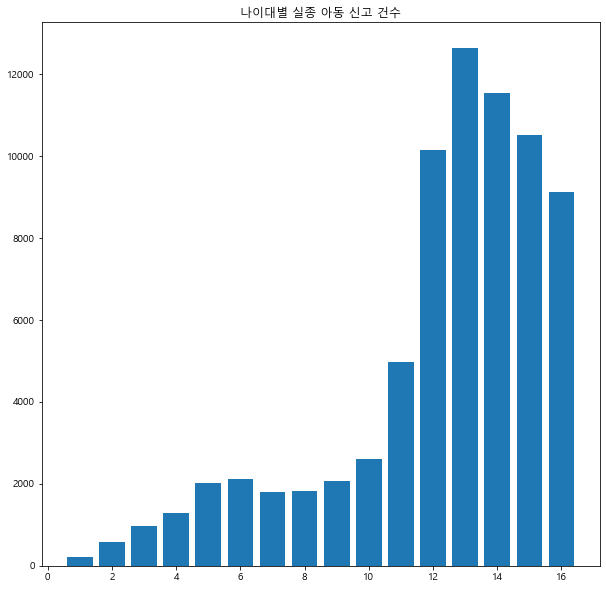

In [30]:
plt.figure(figsize=(10, 10))
plt.title('나이대별 실종 아동 신고 건수')
plt.bar(missing_age_result0['나이'], missing_age_result0['count'])
plt.savefig('./result/나이대별 실종 아동 신고 건수.png')
plt.show()